# Diarization timestamp

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/diarization-timestamp](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization-timestamp).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

### load Speaker Vector

So to know speakers similarity, we can use speaker vector, just load using `malaya_speech.speaker_vector.deep_model`. Read more about malaya-speech Speaker Vector at https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

We are going to compare `conformer-base` and `vggvox-v2`.

In [2]:
model_conformer = malaya_speech.speaker_vector.deep_model('conformer-base')
model_vggvox2 = malaya_speech.speaker_vector.deep_model('vggvox-v2')

### Load audio sample

In [3]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [4]:
# just going to take 60 seconds
y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [5]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

In [6]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

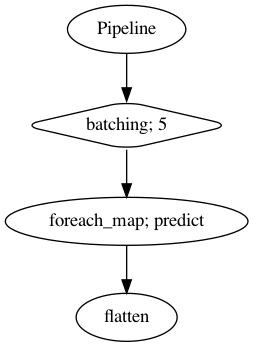

In [7]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [8]:
%%time

result = p(frames)
result.keys()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=480
  n_fft, y.shape[-1]


CPU times: user 1min 2s, sys: 37.5 s, total: 1min 39s
Wall time: 21.2 s


dict_keys(['batching', 'predict', 'flatten'])

In [9]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

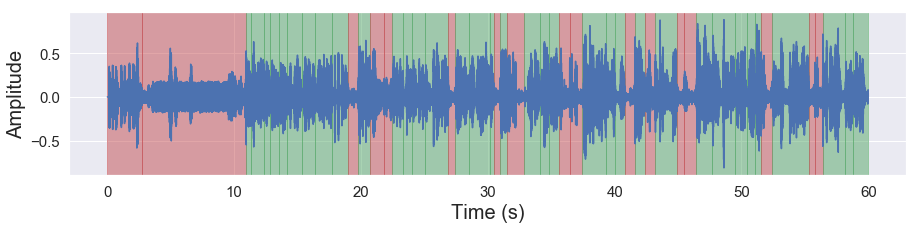

In [10]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

### Load Spectral Clustering

In [11]:
from spectralcluster import SpectralClusterer

clusterer = SpectralClusterer(
    min_clusters=3,
    max_clusters=100,
)

In [13]:
result_diarization_sc_conformer = malaya_speech.diarization.clustering(
    vad_results = grouped_vad, 
    speaker_vector = model_conformer,
    model = clusterer,
)
result_diarization_sc_conformer[:5]

[(<malaya_speech.model.frame.Frame at 0x17e4255d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x17e4155d0>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x1780e8390>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17e4321d0>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x17e415310>, 'speaker 0')]

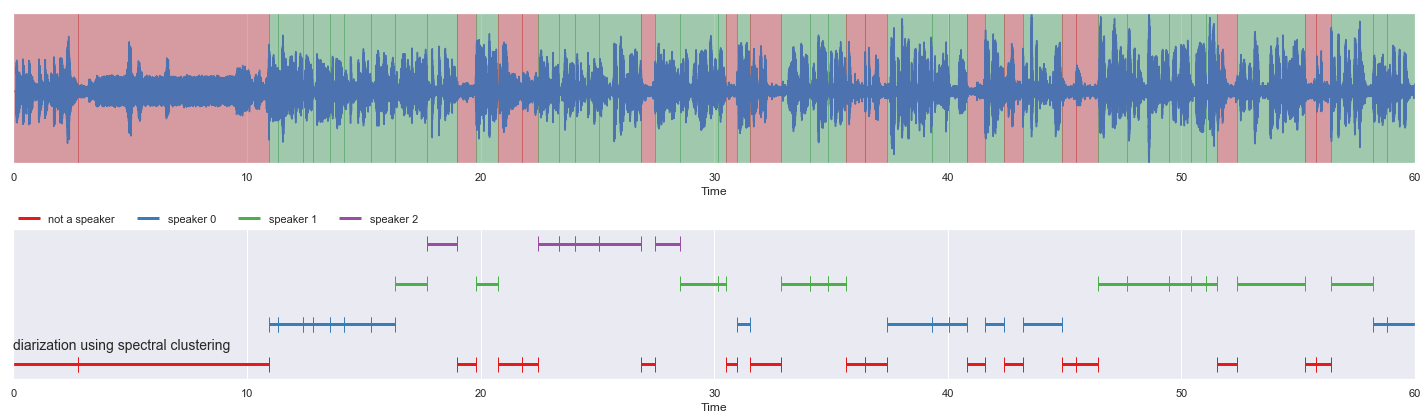

In [14]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization_sc_conformer, 
                                                      'diarization using spectral clustering', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

### How to get timestamp

1. Group multiple frames based on label, this can achieve using `malaya_speech.group.group_frames`.

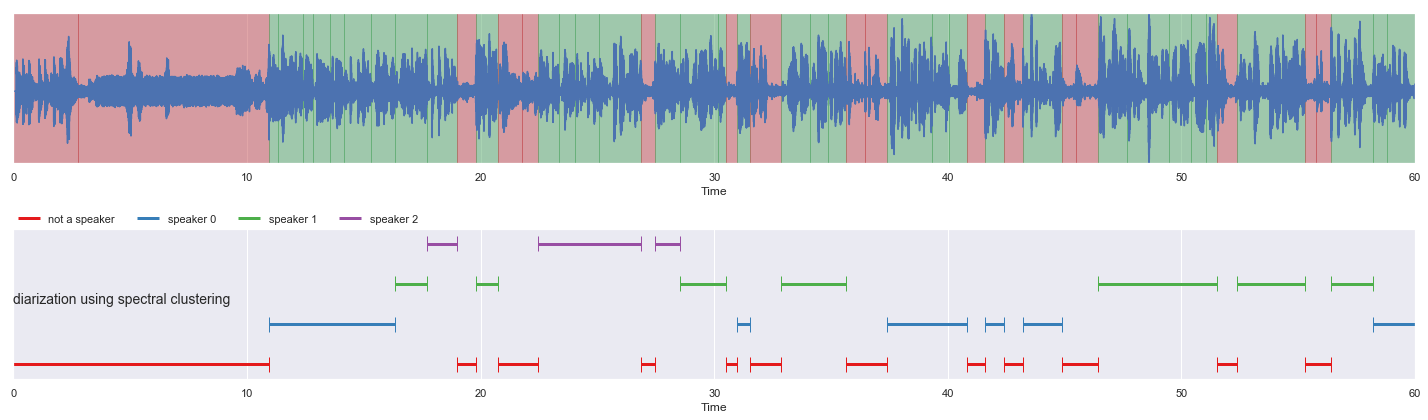

In [15]:
grouped = malaya_speech.group.group_frames(result_diarization_sc_conformer)

nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(grouped, 
                                                      'diarization using spectral clustering', 
                                                      ax = ax[1],
                                                     x_text = 0.01, y_text = 0.5)
fig.tight_layout()
plt.show()

2. Inspect grouped variable.

In [16]:
grouped[0]

(<malaya_speech.model.frame.Frame at 0x1a6346850>, 'not a speaker')

`malaya_speech.model.frame.Frame` stores `timestamp` and `duration` attributes.

In [17]:
grouped[0][0].timestamp, grouped[0][0].duration, grouped[0][1]

(0.0, 10.95000000000002, 'not a speaker')

In [18]:
grouped[1][0].timestamp, grouped[1][0].duration, grouped[1][1]

(10.949999999999958, 5.400000000000001, 'speaker 0')